# Task: Finding the correct sample positions for each train
We have observerd that the sample reconstruction from the ptycho reconstructions appears distorted.<br>
Both position correction as part of the reconstruction as well as an OPR approach did not resolve this issue.<br>
Our last option is to use prior knowledge of the sample, e.g. SEM images. <br>
The goal of this notebook is to collect all the data/info that is availabe and server as a starting point for further position finding analysis.

In [1]:
import h5py 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors 

In [2]:
basedir = "/scratch/fhgfs/xray/p002330/" 
datadir = basedir + "/scan/" 
recodir = basedir + "recons/" 
semdir  = basedir + "sem/" 

## Run 129 - Siemens star - SEM images

In [3]:
import imageio 
sem_fname_011 = semdir + "SPB_SiemensStar_011.tif" 
img1 = np.array(imageio.mimread(sem_fname_011)[0], dtype=float) 

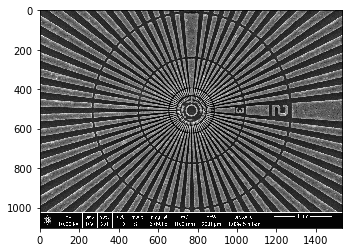

In [4]:
plt.figure()
plt.imshow(img1, cmap='gray', interpolation='none')
plt.show() 

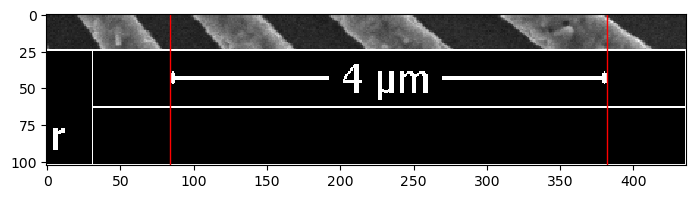

In [5]:
plt.figure(figsize=(10,2), dpi=100)
plt.imshow(img1[1000:,1100:], cmap='gray', interpolation='none')
plt.axvline(84,color='r', lw=1)
plt.axvline(382,color='r', lw=1)
plt.show() 

In [6]:
# 4 microns = 382 - 84 = 298 pixels => 1 px = 13.423 nm
img1_pixel_nm = 13.423 

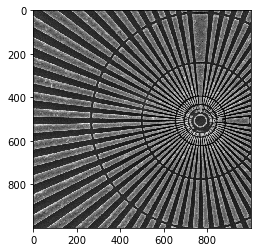

In [7]:
img1_cropped = img1[:1000,:1000]
plt.figure()
plt.imshow(img1_cropped, cmap='gray', interpolation='none')
plt.show()

In [8]:
sem_fname_010 = semdir + "SPB_SiemensStar_010.tif"
img2 = np.array(imageio.mimread(sem_fname_010)[0], dtype=float)

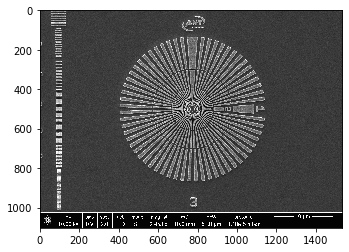

In [9]:
plt.figure()
plt.imshow(img2, cmap='gray', interpolation='none')
plt.show()

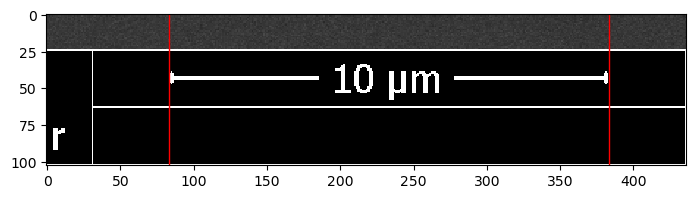

In [10]:
plt.figure(figsize=(10,2), dpi=100)
plt.imshow(img2[1000:,1100:], cmap='gray', interpolation='none')
plt.axvline(83,color='r', lw=1)
plt.axvline(383,color='r', lw=1)
plt.show()

In [11]:
# 10 microns = 383 - 83 = 300 pixels => 1 px = 33.3 nm
img2_pixel_nm = 33.3

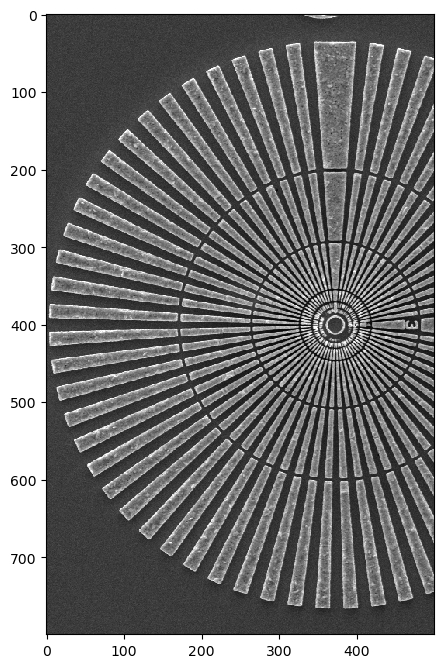

In [12]:
img2_cropped = img2[100:900,400:900]
plt.figure(figsize=(5,10), dpi=100)
plt.imshow(img2_cropped, cmap='gray', interpolation='none')
plt.show()

## Run 129 - Siemens star - DM reconstruction

In [13]:
ptyr_fname = recodir + "r0129_int_DM_0100.ptyr"

In [14]:
with h5py.File(ptyr_fname, 'r') as f:
    probe = f['content/probe/Sscan_00G00/data'][0]
    obj = f['content/obj/Sscan_00G00/data'][0]
    Niter = len(f['content/runtime/iter_info/'])
    defocus = f['content/pars/scans/scan_00/illumination/propagation/parallel'][...]
    errors = np.array([f["content/runtime/iter_info/%05d/error" %i][1] for i in range(Niter)])
    niters = np.array([f["content/runtime/iter_info/%05d/iteration" %i][...] for i in range(Niter)])
    ptycho_pixel_nm = f["content/obj/Sscan_00G00/_psize"][0] * 1e9
    energy = f["content/probe/Sscan_00G00/_energy"][...]
    wavelength = (1.240 / energy) * 1e-9 # m
    distance = f["content/pars/scans/scan_00/data/distance"][...].item()
    detector_shape  = probe.shape
    nx,ny = detector_shape
    cx,cy = detector_shape[1]/2, detector_shape[0]/2

In [15]:
print("pixelize = %.2f nm" %ptycho_pixel_nm)

pixelize = 25.08 nm


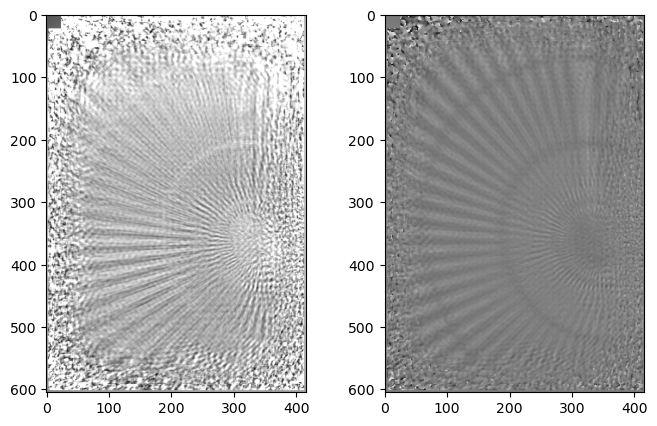

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5), dpi=100)
axes[0].imshow(np.abs(obj), cmap='gray')
axes[1].imshow(np.angle(obj), cmap='gray')
plt.show()

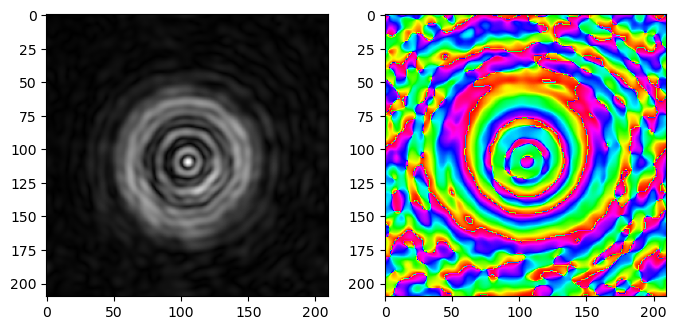

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(8,5), dpi=100)
axes[0].imshow(np.abs(probe), cmap='gray')
axes[1].imshow(np.angle(probe), cmap='hsv')
plt.show()

## Run 129 - Siemens star - Diffraction data

In [18]:
data_fname = datadir + "r0129.h5"
with h5py.File(data_fname, "r") as f:
    trid = f["DA03/INDEX"][:]
    posy = f["DA03/ACTY"][:]
    posz = f["DA03/ACTZ"][:]
    flux = f["DA03/FLUX"][:]
    pind = f["DA03/posindex"][:]
    print(f["AGIPD/data"].shape)
    data = f["AGIPD/data"][1]
    print(f["AGIPD/data"][0].shape)

(12925, 220, 210, 210)
(220, 210, 210)


In [19]:
print(posy.shape)

(12925,)


In [20]:
# Mask is boolean array 
data_fname_sin = datadir + "r0129_sin.h5"
with h5py.File(data_fname_sin, "r") as f:
    mask = f["AGIPD/mask"][:]
    
# Print unique values in the mask
print("Unique values in the mask: %s." % np.unique(mask)) 

Unique values in the mask: [False  True].


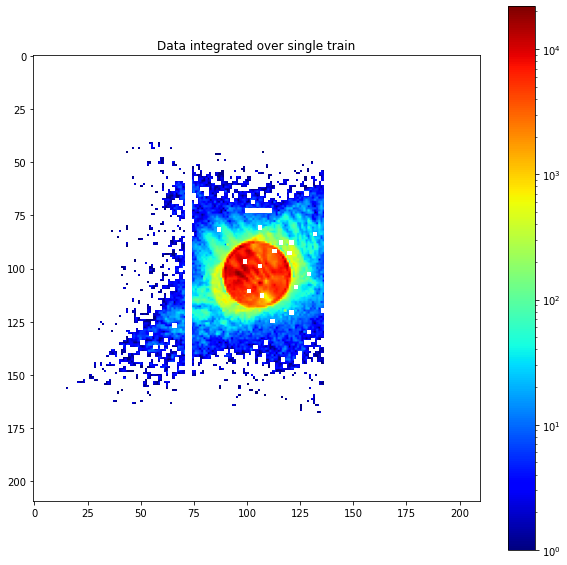

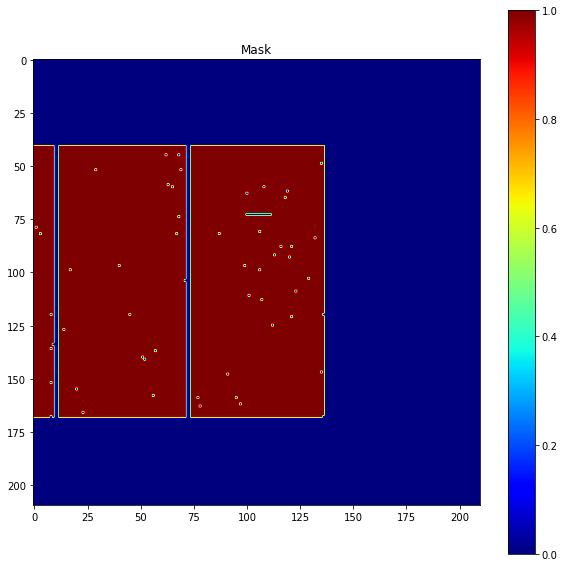

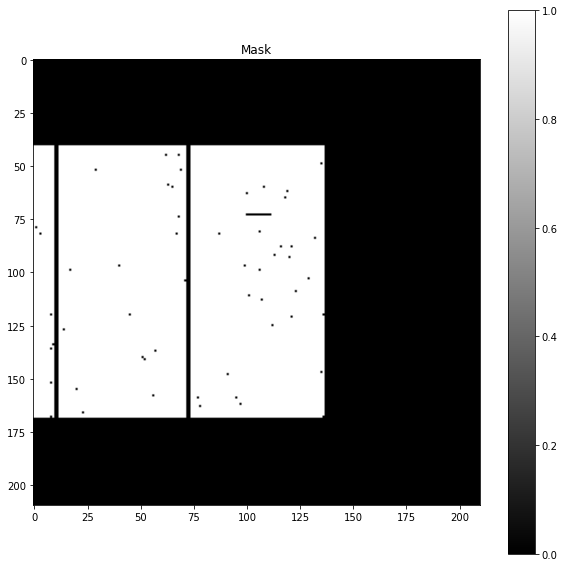

In [22]:
color_map = 'jet'

plt.figure(1, figsize = (10,10))
plt.title("Data integrated over single train")
plt.imshow(data.sum(axis=0)*mask, cmap = color_map, norm=colors.LogNorm())
plt.colorbar()

plt.figure(2, figsize = (10,10)) 
plt.title("Mask") 
plt.imshow(mask, cmap = color_map)
plt.colorbar()

plt.figure(3, figsize = (10,10)) 
plt.title("Mask") 
plt.imshow(mask, cmap = 'gray')
plt.colorbar()

/tmp/ipykernel_7465/1210905002.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(posy, posz, "r-", lw=0.5, ls='--')


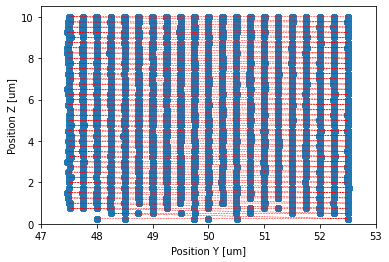

In [23]:
plt.figure() 
plt.plot(posy, posz, "r-", lw=0.5, ls='--') 
plt.scatter(posy, posz) 
#plt.colorbar(label="Nr. of pulses") 
plt.xlabel("Position Y [um]") 
plt.ylabel("Position Z [um]") 
plt.xlim(47,53) 
plt.ylim(0,10.5) 
plt.show() 

In [ ]:
# Closing file 
agipd_data.close() 
agipd_mask.close() 